In [260]:
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import train_test_split, TimeSeriesSplit


## Dataset

In [52]:
start = "2022-01-01"
end = "2023-01-01"
df = yf.download('BTC-USD', start = start, end = end)

[*********************100%***********************]  1 of 1 completed


In [125]:
warnings.filterwarnings("ignore")

## EDA

In [56]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004
2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547
2022-01-03,47343.542969,47510.726562,45835.964844,46458.117188,46458.117188,33071628362
2022-01-04,46458.851562,47406.546875,45752.464844,45897.574219,45897.574219,42494677905
2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,43569.003906,36851084859


In [53]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,16642.341797,14472237479
2022-12-30,16641.330078,16643.427734,16408.474609,16602.585938,16602.585938,15929162910
2022-12-31,16603.673828,16628.986328,16517.519531,16547.496094,16547.496094,11239186456


In [54]:
# Cut Close column
close = df[["Close"]]

In [55]:
close.shape

(365, 1)

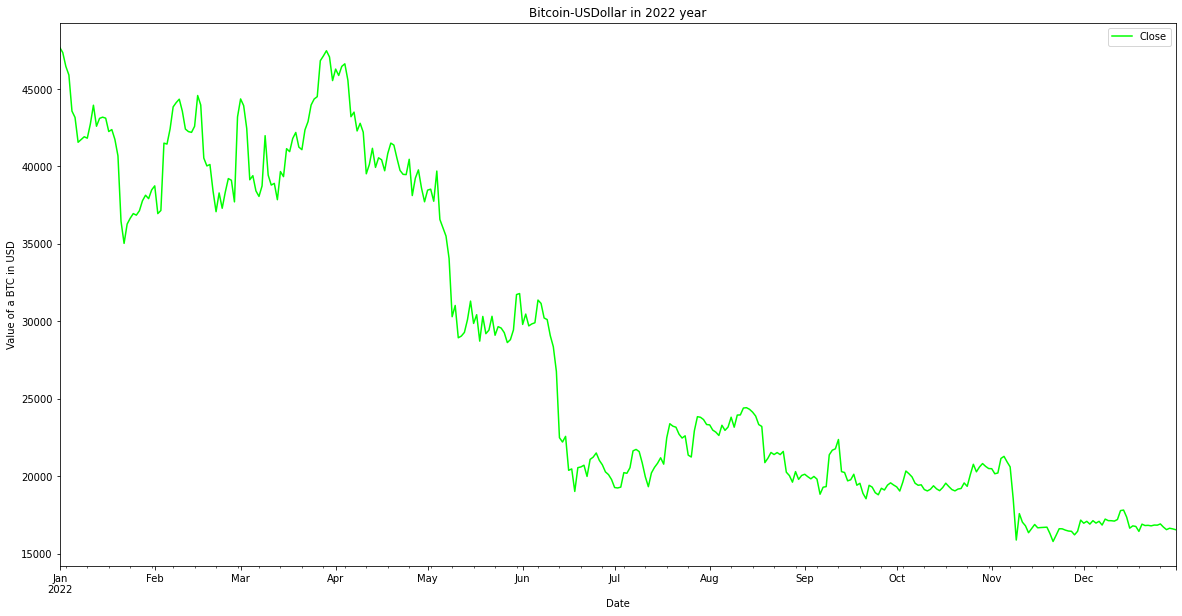

In [90]:
close.plot(y = "Close", title = "Bitcoin-USDollar in 2022 year", ylabel = "Value of a BTC in USD", figsize = (20,10), c = 'lime')
plt.show()

### Trend | Seasonal | Residual


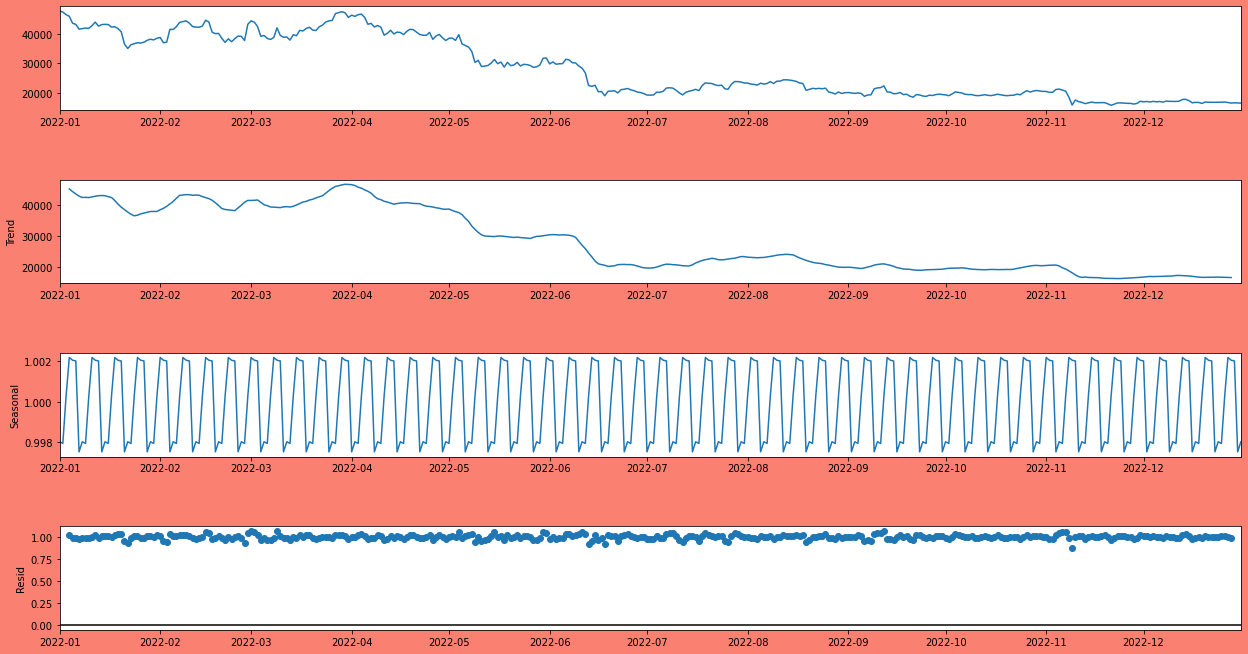

In [98]:
decompose_result = seasonal_decompose(close, model = "multiplicative")
fig_decompose = decompose_result.plot()
fig_decompose.set_size_inches((20,10))
fig_decompose.set_facecolor("salmon")
plt.show()

## Stationary?

In [59]:
# It's clear from the above plot that data is non-stationary
# But always we can double check it with adfuller test
result_adfuller = adfuller(close)
pvalue = result_adfuller[1]
print(pvalue)
if pvalue < 0.05:
    print("stationary")
else:
    print("non-stationary")

0.4980422119758229
non-stationary


### diff(1) is stationary

In [60]:
result_adfuller = adfuller(close.diff(1).dropna())
pvalue = result_adfuller[1]
print(result_adfuller)
if pvalue < 0.05:
    print("stationary")
else:
    print("non-stationary")

(-6.511663266376589, 1.0965396229476219e-08, 9, 354, {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}, 5776.594904372578)
stationary


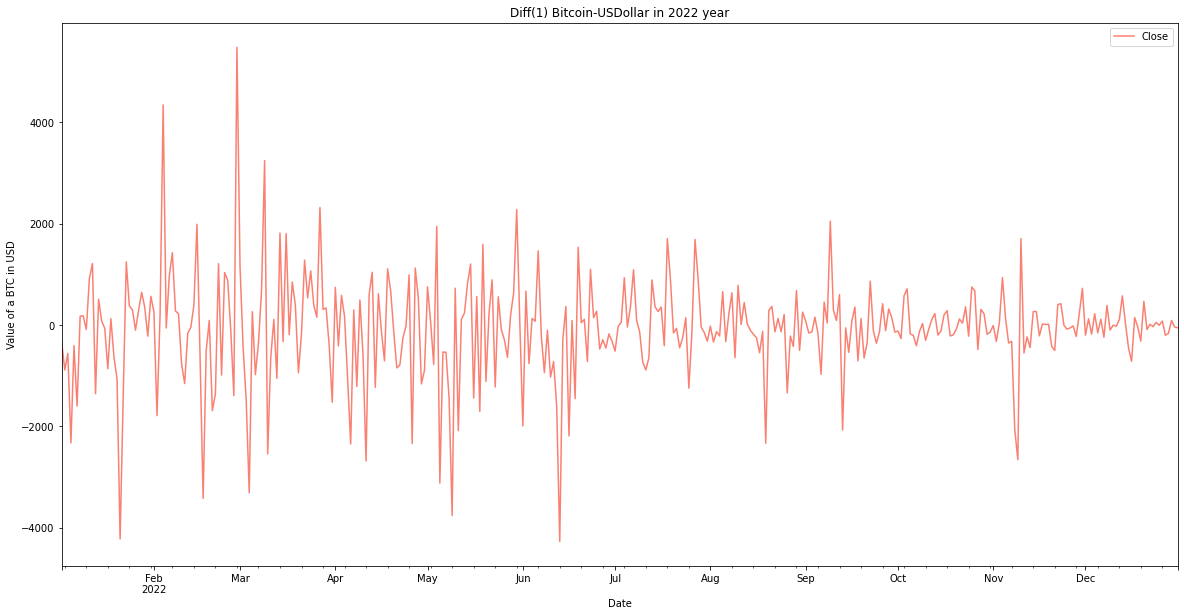

In [87]:
close.diff(1).dropna().plot(y = "Close", title = "Diff(1) Bitcoin-USDollar in 2022 year", ylabel = "Value of a BTC in USD", figsize = (20,10), c = 'salmon')
plt.show()

## ACF/PACF

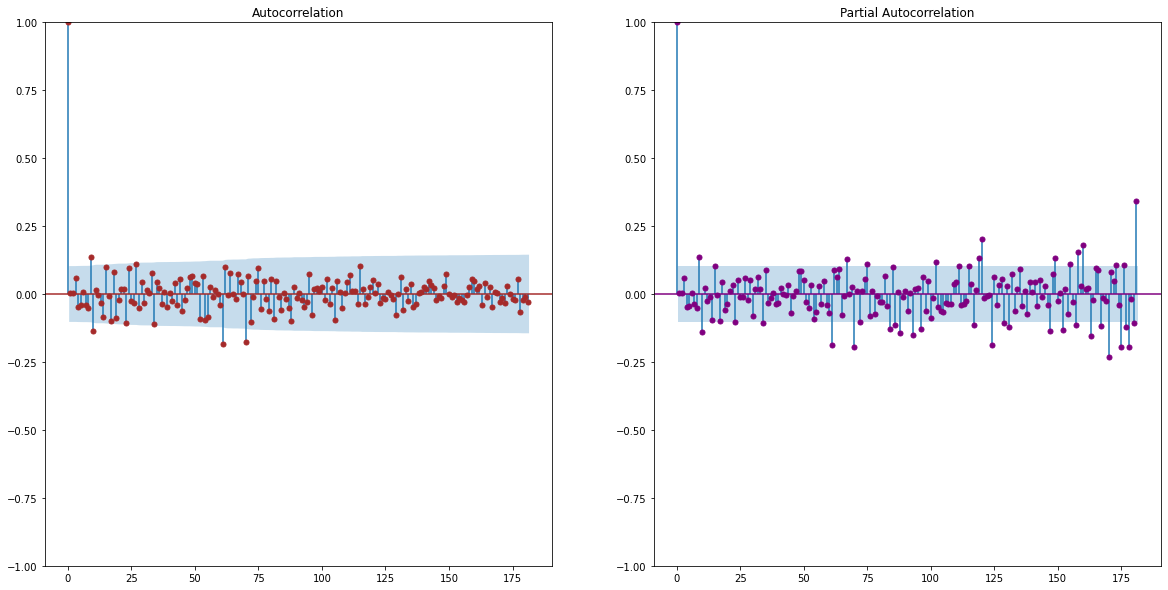

In [85]:
fig, (ax1,ax2) = plt.subplots(figsize = (20,10), ncols = 2)
plot_acf(close.diff(1).dropna(), ax = ax1, lags = 181, c = 'brown')
plot_pacf(close.diff(1).dropna(), ax = ax2, lags = 181, c = 'purple')
plt.show()

## Classic

### ARIMA

### Grid Search ARIMA

In [130]:
# Normalization included
train, test = train_test_split(close, test_size = 0.2 , shuffle = False)
sclaer_close = MinMaxScaler()
sclaer_close.fit(train)
train_normal = pd.DataFrame(
    {
        'date' : train.index.values,
        'Close': np.squeeze(sclaer_close.transform(train))
    } ).set_index(["date"])

test_normal = pd.DataFrame(
    {
        'Close' : np.squeeze(sclaer_close.transform(test)),
        'date' : test.index.values
    } 
    ).set_index(["date"])

grid_search_arima = []
for p in range(4):
    for d in range(1,4):
        for q in range(4):
            train, test = train_normal, test_normal
            fcst = []
            for step in range(test.shape[0]):
                mod = ARIMA(train, order = (p,d,q))
                res = mod.fit()
                fcst.append(res.forecast(steps = 1))
                train = train.append(pd.Series(test.iloc[step]))
            score = r2_score(test,fcst)
            print([score,p,d,q])
            grid_search_arima.append([score,p,d,q])
# 37m 32.6s

[0.8854319527575117, 0, 1, 0]
[0.8850955420937262, 0, 1, 1]
[0.8854612463597086, 0, 1, 2]
[0.8854622549125102, 0, 1, 3]
[0.7796528542465546, 0, 2, 0]
[0.8318518264183714, 0, 2, 1]
[0.8727429804866794, 0, 2, 2]
[0.867670218285602, 0, 2, 3]
[0.37391031487549553, 0, 3, 0]
[0.7786583087458491, 0, 3, 1]
[0.8467557587524543, 0, 3, 2]
[0.8498555191698567, 0, 3, 3]
[0.8851074939783266, 1, 1, 0]
[0.885274078874407, 1, 1, 1]
[0.8842383865409597, 1, 1, 2]
[0.8837112131385826, 1, 1, 3]
[0.8103569243706135, 1, 2, 0]
[0.8603035730061337, 1, 2, 1]
[0.8627706333702383, 1, 2, 2]
[0.8553615389505522, 1, 2, 3]
[0.5813222659515732, 1, 3, 0]
[0.8172947881580833, 1, 3, 1]
[0.8659144689567099, 1, 3, 2]
[-1319399539.9551177, 1, 3, 3]
[0.8854124660904729, 2, 1, 0]
[0.884001023202044, 2, 1, 1]
[0.8832471408622459, 2, 1, 2]
[0.8754188416168044, 2, 1, 3]
[0.8341710822368469, 2, 2, 0]
[0.8626149824503869, 2, 2, 1]
[0.8594161464080976, 2, 2, 2]
[0.8606761178901783, 2, 2, 3]
[0.7049268240315057, 2, 3, 0]
[0.83404385

In [138]:
grid_search_arima_df = pd.DataFrame(grid_search_arima, columns = ['score','p','d','q'])

### Best ARIMA order

In [140]:
grid_search_arima_df = grid_search_arima_df.sort_values(["score"], ascending = False).reset_index(drop = True)
grid_search_arima_df.head()

,score,p,d,q
0,0.885462,0,1,3
1,0.885461,0,1,2
2,0.885443,3,1,0
3,0.885432,0,1,0
4,0.885412,2,1,0


### p = 0, d = 1, q = 3

Normalization NOT included

In [292]:
p = 0
d = 1
q = 3
train, test = train_test_split(close, test_size = 0.3 , shuffle = False)
fcst = []
for step in range(test.shape[0]):
    mod = ARIMA(train, order = (p,d,q))
    res = mod.fit()
    fcst.append(res.forecast(steps = 1))
    train = train.append(pd.Series(test.iloc[step]))
score = r2_score(test,fcst)
print(score)
forecast = pd.DataFrame(
    {
        'fcst' : [element.values[0] for element in fcst],
        'date' : [element.index[0] for element in fcst]
    }).set_index(["date"])

0.8867113362919591


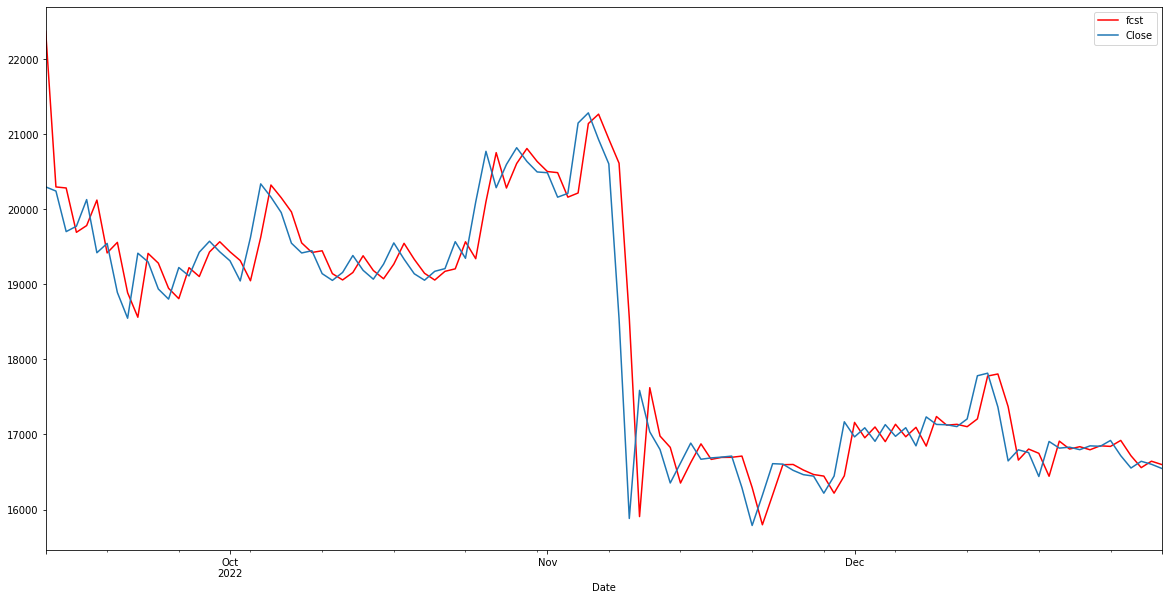

In [295]:
fig, ax4 = plt.subplots(figsize = (20,10))
forecast.plot(c = 'red', ax = ax4)
test.plot( ax = ax4)
plt.show()

Normalization included


In [289]:
p = 0
d = 1
q = 3
train, test = train_test_split(close, test_size = 0.3 , shuffle = False)
sclaer_close = MinMaxScaler()
sclaer_close.fit(train)
train_normal = pd.DataFrame(
    {
        'date' : train.index.values,
        'Close': np.squeeze(sclaer_close.transform(train))
    } ).set_index(["date"])

test_normal = pd.DataFrame(
    {
        'Close' : np.squeeze(sclaer_close.transform(test)),
        'date' : test.index.values
    } 
    ).set_index(["date"])
fcst = []
for step in range(test_normal.shape[0]):
    mod = ARIMA(train_normal, order = (p,d,q))
    res = mod.fit()
    fcst.append(res.forecast(steps = 1))
    train_normal = train_normal.append(pd.Series(test_normal.iloc[step]))
score = r2_score(test_normal,fcst)
print(score)
forecast_normal = pd.DataFrame(
    {
        'fcst' : [element.values[0] for element in fcst],
        'date' : [element.index[0] for element in fcst]
    }).set_index(["date"])

0.8846762188442583


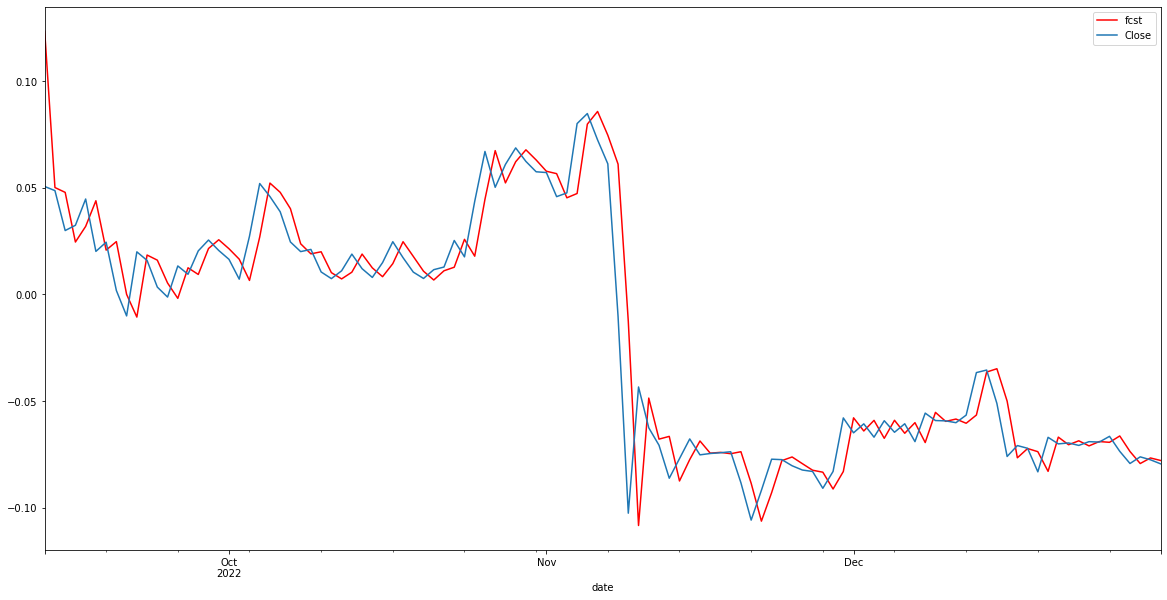

In [279]:
fig, ax5 = plt.subplots(figsize = (20,10))
forecast_normal.plot(c = 'red', ax = ax5)
test_normal.plot( ax = ax5)
plt.show()

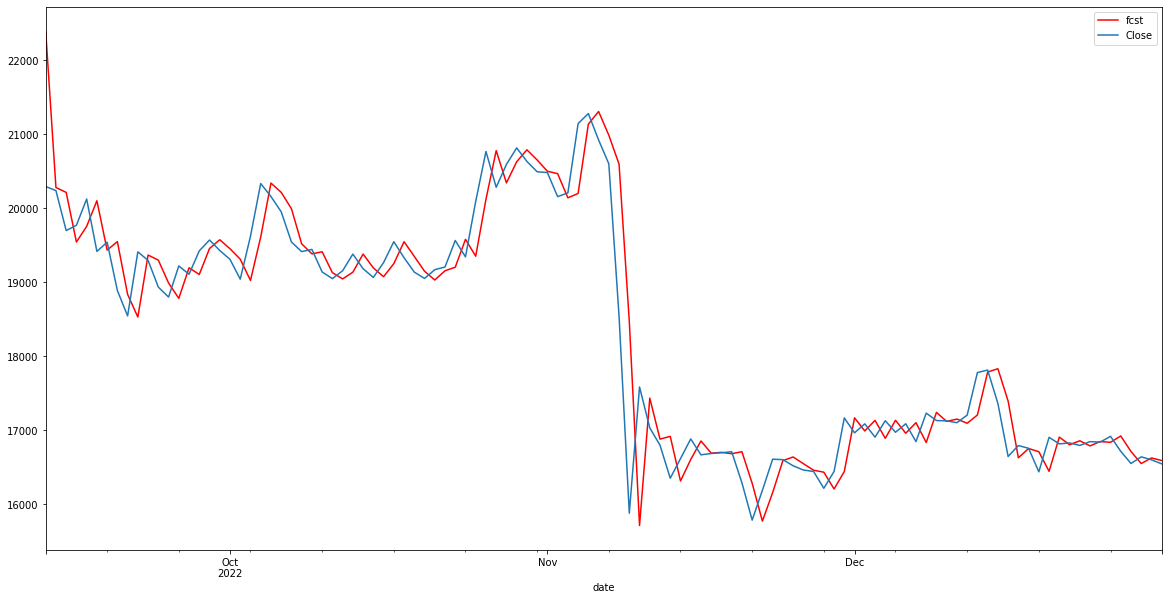

In [286]:
forecast = pd.DataFrame({
    "fcst" : np.squeeze(sclaer_close.inverse_transform(forecast_normal.fcst.to_numpy().reshape(-1,1))),
    "date" : forecast_normal.index.values
    }
    ).set_index(["date"])
test = pd.DataFrame({
    "Close" : np.squeeze(sclaer_close.inverse_transform(test_normal.Close.to_numpy().reshape(-1,1))),
    "date" : test_normal.index.values
    }
    ).set_index(["date"])


fig, ax6 = plt.subplots(figsize = (20,10))
forecast.plot(c = 'red', ax = ax6)
test.plot( ax = ax6)
plt.show()

### Grid search using Time Series Cross Validation to check top 5 orders in grid_search_arima_df

In [201]:
tscv = TimeSeriesSplit(test_size = 30)
tscv_details = []
candidate_orders = grid_search_arima_df[["p","d","q"]].head().to_numpy().tolist()
for co in candidate_orders:
    temp_score = []
    for train_index, test_index in tscv.split(close):
        train = close.iloc[train_index]
        test = close.iloc[test_index]
        fcst = []
        for step in range(test.shape[0]):
            mod = ARIMA(train, order = (co[0],co[1],co[2]))
            res = mod.fit()
            fcst.append(res.forecast(steps = 1))
            train = train.append(pd.Series(test.iloc[step]))
        score = r2_score(test,fcst)
        temp_score.append(score)
    print(temp_score,co[0],co[1],co[2])
    tscv_details.append([np.mean(temp_score),co[0],co[1],co[2] ])

[0.8567478422682001, 0.47969062624853687, 0.6919114604772575, 0.7965808610142247, 0.38313559587797996] 0 1 3
[0.8568243135219858, 0.4805764027584758, 0.6915090998800211, 0.7965759730823092, 0.3866382529836182] 0 1 2
[0.8569427935231386, 0.4798458743764342, 0.6915193428701275, 0.7965310946827082, 0.3831905805842123] 3 1 0
[0.8578230971433107, 0.48219244565304076, 0.6889105161081359, 0.796636422224791, 0.38550480383248475] 0 1 0
[0.8569989252596167, 0.48074546157369635, 0.6911095520689807, 0.796479597274001, 0.3866135552996165] 2 1 0


In [202]:
tscv_details

[[0.6416132771772398, 0, 1, 3],
 [0.642424808445282, 0, 1, 2],
 [0.6416059372073242, 3, 1, 0],
 [0.6422134569923527, 0, 1, 0],
 [0.6423894182951824, 2, 1, 0]]

In [251]:
# Author : amyrmahdy
# Date : 12 Jan 2023